In [1]:
import pandas as pd
import numpy as np
import gudhi as gd
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
from gudhi.hera import wasserstein_distance
from gudhi.representations import PersistenceImage
from gudhi.representations.metrics import WassersteinDistance
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import MDS
import os
from tqdm.notebook import tqdm

#%matplotlib widget

In [2]:
datapath =".\\data\\timeseries\\good_new"
filelist = os.listdir(datapath)
print(sorted(filelist))
good_time_series = [np.array(pd.read_csv(os.path.join(datapath,f), header=None)[0]) for f in sorted(filelist)]
datapath =".\\data\\timeseries\\bad_new"
filelist = os.listdir(datapath)
print(sorted(filelist))
bad_time_series = [np.array(pd.read_csv(os.path.join(datapath,f), header=None)[0]) for f in sorted(filelist)]

print(good_time_series[0])

['sig1_good.txt', 'sig2_good.txt', 'sig3_good.txt', 'sig4_good.txt', 'sig5_good.txt']
['sig1_bad.txt', 'sig2_bad.txt', 'sig3_bad.txt', 'sig4_bad.txt', 'sig5_bad.txt']
[-0.11156466  0.01043311  0.30969176 ...  0.44117724  0.98839737
 -2.1306849 ]


In [3]:
n_chunks = 200
chopped_good_ts = [[]]*len(good_time_series)
chopped_bad_ts = [[]]*len(bad_time_series)
chunks = np.array_split(range(0,len(good_time_series[0])), n_chunks)
for i in range(0,len(good_time_series)):
    chopped_good_ts[i] = np.array_split(good_time_series[i], n_chunks)
    chopped_bad_ts[i] = np.array_split(bad_time_series[i], n_chunks)

In [4]:
dim = 2
delay =7
skip = 1
good_point_clouds = [[]]*len(good_time_series)
bad_point_clouds = [[]]*len(bad_time_series)

tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)

for i in range(0,len(good_time_series)):
    good_point_clouds[i] = tde.transform(chopped_good_ts[i])
    bad_point_clouds[i] = tde.transform(chopped_bad_ts[i])

In [5]:
good_pds = [[]]*len(good_time_series)

for i in range(0,len(good_point_clouds)):
    for pc in good_point_clouds[i]:
        ac = gd.AlphaComplex(pc)
        st = ac.create_simplex_tree()
        st.compute_persistence()
        good_pds[i].append(st.persistence_intervals_in_dimension(1))

bad_pds = [[]]*len(bad_time_series)

for i in range(0,len(bad_point_clouds)):
    for pc in bad_point_clouds[i]:
        ac = gd.AlphaComplex(pc)
        st = ac.create_simplex_tree()
        st.compute_persistence()
        bad_pds[i].append(st.persistence_intervals_in_dimension(1))

In [6]:
outlier_chunks = []
dist_matrix = np.zeros((len(good_pds),n_chunks))
for j in range(0,len(good_pds)):
    print(j)
    for i in tqdm(range(0,n_chunks)):
        dist = gd.hera.wasserstein_distance(good_pds[j][i],bad_pds[j][i], internal_p = 2, order = 2)
        dist_matrix[j][i] = dist
        #if dist > 0:
            #print(i)
            #print(dist)
            #print(chunks[i])
            #outlier_chunks.append(i)

0



1



2



3



4


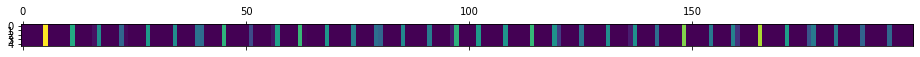

In [7]:
plt.matshow(dist_matrix)

In [8]:
ts_dist_matrix = np.zeros((len(good_pds),n_chunks))
for j in range(0,len(good_time_series)):
    for i in range(0,n_chunks):
        diff = chopped_good_ts[j][i]-chopped_bad_ts[j][i]
        #print(j,i,diff)
        ts_dist_matrix[j][i] = np.abs(np.mean(diff))

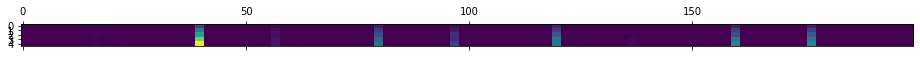

In [9]:
plt.matshow(ts_dist_matrix)